# MASS visual characterization of spindle annotations

In [4]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
#import kaleido

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath= os.environ['DATAPATH']
masspath= datapath+'/MASS'


## open MASS


In [5]:
signals, annotations, signalsMetadata = loadMASSSpindles(masspath,returnSignals=True)

In [6]:
annotations

,type,subjectId,startTime,duration,expert,comment,labelerId,samplerate,stopTime,startInd,stopInd
0,spindle,0001,888.569501,0.640579,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,256,889.210080,227474,227638
1,spindle,0001,905.999757,0.578094,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,256,906.577851,231936,232084
2,spindle,0001,917.973270,0.847603,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,256,918.820873,235001,235218
3,spindle,0001,922.319885,0.878845,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,256,923.198730,236114,236339
4,spindle,0001,939.297141,0.757767,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,256,940.054908,240460,240654
...,...,...,...,...,...,...,...,...,...,...,...
33453,spindle,0019,25434.045319,0.800730,E2,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0002,256,25434.846049,6511116,6511321
33454,spindle,0019,25438.822357,0.472626,E2,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0002,256,25439.294983,6512339,6512460
33455,spindle,0019,25444.489963,1.035090,E2,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0002,256,25445.525053,6513789,6514054
33456,spindle,0019,25457.542096,0.890568,E2,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0002,256,25458.432664,6517131,6517359


### visualise one spindle

In [7]:
subject='0001'
aux=signalsMetadata.loc[signalsMetadata.subjectId==subject]
signal=signals[subject]
timepoints=np.arange(len(signal))/aux.samplerate[0]
thisAnnotations=annotations.loc[annotations['subjectId']==subject].copy()

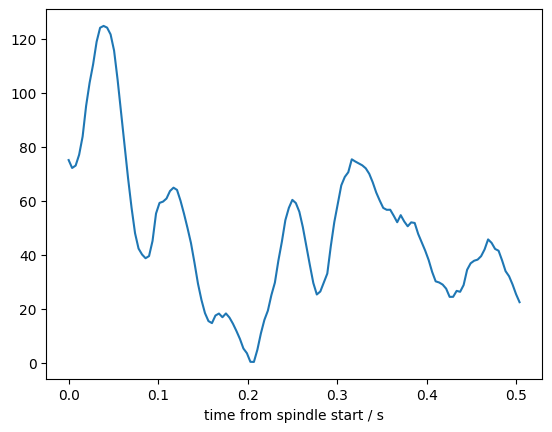

In [8]:
#just make a quick plot of the spindle with index i (longest spindle with i=491)
i=1542

info=thisAnnotations.iloc[i]

plt.plot(timepoints[info.startInd:info.stopInd]-timepoints[info.startInd],signals[info.subjectId][info.startInd:info.stopInd])
plt.xlabel("time from spindle start / s")
plt.show()


In [9]:
def getCharacteristicFreqsFromRow(row,signal,samplerate,freqRange,fftResolution=2048):
    signal=signal[row.subjectId]
    segment=signal[row.startInd:row.stopInd]
    #directly tappering with hamming
    tap=np.hamming(len(segment))
    segment=segment*tap
    freq = fft.fftfreq(fftResolution, 1/samplerate)
    ffSegment=fft.fft(segment,fftResolution)
    roi=(freq>=freqRange[0]) & (freq<=freqRange[1])
    PSDSegment,power=getPSD(ffSegment[roi],returnFactor=True)
    peakFreq=freq[roi][np.argmax(PSDSegment)]
    medianFreq=freq[roi][getMedianPSDIndex(PSDSegment)]
    return [peakFreq, medianFreq, power]

In [10]:
#define region of interest
freqRoi=[8,16]

In [11]:
thisAnnotations[['peakFreq','medianFreq','power']]=thisAnnotations.apply(lambda x: 
getCharacteristicFreqsFromRow(x,signals,aux.samplerate[0],freqRoi)
,axis=1, result_type ='expand')

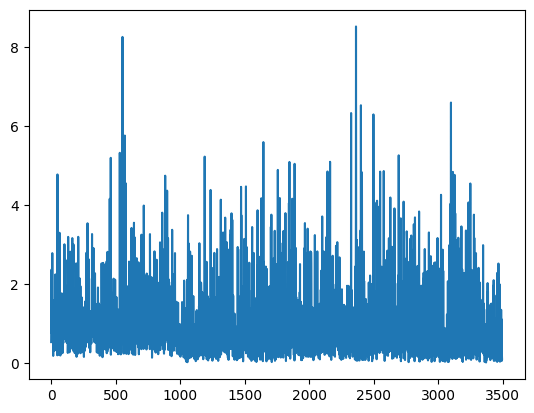

In [12]:
allpower=thisAnnotations.power
plt.plot(thisAnnotations.power/np.mean(thisAnnotations.power))
plt.show()

#we may have some outliers...

number of annotations not represented: 125


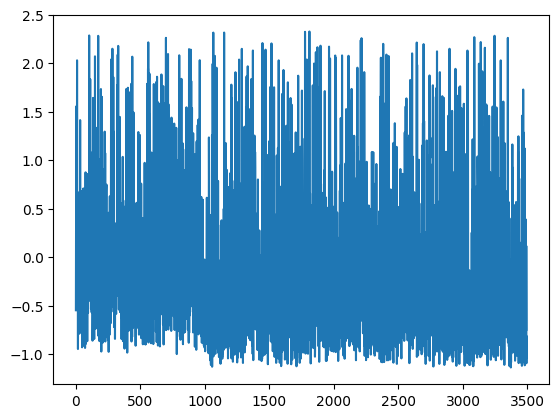

In [13]:
powerMean=np.mean(allpower)
powerStd=np.std(allpower)
allpowerZS=(allpower-powerMean)/powerStd
allpowerZS=allpowerZS[allpowerZS<2.33]
plt.plot(allpowerZS)
print("number of annotations not represented: "+str(len(thisAnnotations)-np.sum(allpowerZS<2.33)))

In [18]:
annotations

,type,subjectId,startTime,duration,expert,comment,labelerId,samplerate,stopTime,startInd,stopInd
0,spindle,0001,888.569501,0.640579,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,256,889.210080,227474,227638
1,spindle,0001,905.999757,0.578094,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,256,906.577851,231936,232084
2,spindle,0001,917.973270,0.847603,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,256,918.820873,235001,235218
3,spindle,0001,922.319885,0.878845,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,256,923.198730,236114,236339
4,spindle,0001,939.297141,0.757767,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,256,940.054908,240460,240654
...,...,...,...,...,...,...,...,...,...,...,...
33453,spindle,0019,25434.045319,0.800730,E2,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0002,256,25434.846049,6511116,6511321
33454,spindle,0019,25438.822357,0.472626,E2,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0002,256,25439.294983,6512339,6512460
33455,spindle,0019,25444.489963,1.035090,E2,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0002,256,25445.525053,6513789,6514054
33456,spindle,0019,25457.542096,0.890568,E2,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0002,256,25458.432664,6517131,6517359


In [25]:
def saveSpindleFreqsGraphII(row,signal,freqRange,fftResolution=2048,folder="./characteristicFreqsImagesII"):
    if not os.path.isdir(folder):
        os.mkdir(folder)

    fig = sb.make_subplots(rows=2, cols=1, row_heights=[0.3, 0.7],specs=[[{}],[{"secondary_y": True}]])

    signal=signals[row.subjectId]
    segment=signal[row.startInd:row.stopInd]
    #directly tappering with hamming
    tap=np.hamming(len(segment))
    segment=segment*tap
    freq = fft.fftfreq(fftResolution, 1/row.samplerate)
    ffSegment=fft.fft(segment,fftResolution)
    roi=(freq>=freqRange[0]) & (freq<=freqRange[1])
    PSDSegment,power=getPSD(ffSegment[roi],returnFactor=True)
    peakFreq=freq[roi][np.argmax(PSDSegment)]
    medianFreq=freq[roi][getMedianPSDIndex(PSDSegment)]

    #upper plot
    graphPoints=seconds2index(5,row.samplerate)
    segmentPoints=row.stopInd-row.startInd
    auxStart=int(row.startInd-(graphPoints-segmentPoints)/2)
    auxStop=auxStart+graphPoints
    fig.add_trace(go.Scatter(x=timepoints[auxStart:auxStop]-timepoints[row.startInd], y=signals[row.subjectId][auxStart:auxStop]),
                row=1, col=1)
    fig.data[-1].name = '5 seconds of signal'
    fig.add_vline(x=0,line=dict(dash='dot',color='black'),
                row=1, col=1)
    fig.add_vline(x=timepoints[row.stopInd]-timepoints[row.startInd],line=dict(dash='dot',color='black'),
                row=1, col=1)
    fig.update_xaxes(title_text="time from spindle start / s",
                row=1, col=1)

    #lower plot
    fig.add_trace(go.Line(x=freq[roi],y=PSDSegment),
                row=2, col=1,secondary_y=False)
    fig.data[-1].name = 'PSD'
    fig.update_yaxes(rangemode="nonnegative",
                row=2, col=1,secondary_y=False)
    fig.add_trace(go.Line(x=freq[roi],y=np.cumsum(PSDSegment), fill='tozeroy',fillcolor='rgba(180,0,0,0.2)', mode='lines' ,line=dict(dash='dot',color='rgba(180,0,0,0.2)')),
                row=2, col=1,secondary_y=True)
    fig.data[-1].name = 'cummulative sum'
    fig.add_vline(x=medianFreq,line=dict(dash='dot',color='green'),
                row=2, col=1)
    fig.add_vline(x=peakFreq,line=dict(dash='dash',color='yellow'),
                row=2, col=1)
    fig.add_hline(y=0.5,line=dict(dash='dot',color='rgba(30,30,30,0.6)'),
                row=2, col=1,secondary_y=True)

    fig.update_yaxes(title_text="<b>PSD</b>",
                row=2, col=1, secondary_y=False)
    fig.update_yaxes(title_text="cummulative sum",
                row=2, col=1, secondary_y=True)
    fig.update_xaxes(title_text="<b>frequency / Hz<b>",
                row=2, col=1)

    plotly.io.write_image(fig,folder+"/"+row.subjectId+"_"+row.expert+"_"+str(row.name).zfill(4)+"_spindle_visual_test.png")

In [26]:
#uncomment and run if you don't have the images, check under in your project folder (should take less than 5 mins)
aux=annotations.apply(lambda x: 
    saveSpindleFreqsGraphII(x,signals,freqRoi,folder=masspath+"/graphical/annotationPSD")
    ,axis=1)

del aux

c:\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


